In [237]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [238]:
train_df = pd.read_csv('/Users/macbookpro/Desktop/lxc/git/MMA_Enterprise/Revenue-Radar/Data/train_df.csv')

null = []
for n in train_df.columns:
    if train_df[n].nunique(dropna=False) == 1:
        null.append(n)

null

/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_7267/1626016371.py:1: DtypeWarning:

Columns (2,34) have mixed types. Specify dtype option on import or set low_memory=False.



[]

In [239]:
train_df.head()
train_df.columns.to_list()



['channelGrouping',
 'date',
 'fullVisitorId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.isTrueDirect',
 'trafficSource.referralPath',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adContent',
 'trafficSource.campaignCode']

In [240]:
import itertools

columns = sorted(train_df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

for group in grouped_columns:
    print(", ".join(group))

channelGrouping
date, device.browser, device.deviceCategory, device.isMobile, device.operatingSystem
fullVisitorId
geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent
totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue, trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.isVideoAd, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.campaignCode, trafficSource.isTrueDirect, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source
visitId, visitNumber, visitStartTime


In [241]:
#drop the columns that have not available in demo dataset
columns_to_drop = [col for col in train_df.columns if train_df[col].eq('NaN').any()]
df_dropped = train_df.drop(columns=columns_to_drop)




In [242]:
#check the na percentage compare to total data
na_percentage = df_dropped.isna().sum() / len(df_dropped)
na_percentage = na_percentage.sort_values(ascending=False)

na_percentage




trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
totals.newVisits                                0.221980
totals.pageviews                                0.000111
trafficSource.medium                            0.000000
trafficSource.source                            0.000000
trafficSource.campaign                          0.000000
channelGrouping                

Percentage of customers producing revenue: 1.40%

In [243]:
import numpy as np
import pandas as pd

gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")

gdf = gdf.dropna(subset=["totals.transactionRevenue"])

gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])

total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100

print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))


Percentage of customers producing revenue: 1.40%


## Regression model on revenue (Only with data that percentage of customers producing data)

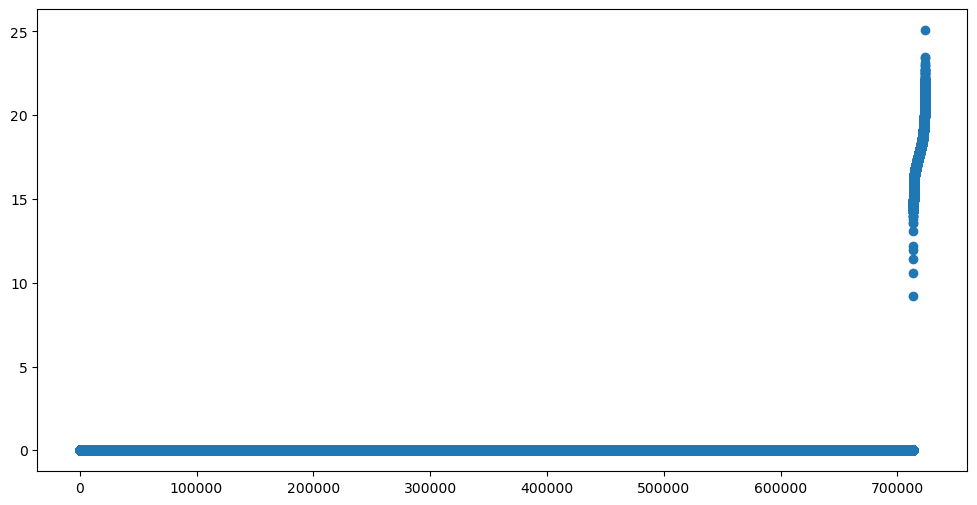

In [244]:
# Plotting the distribution of the total revenue
plt.figure(figsize=(12,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))

In [245]:
# check how many data we have for each column
count = df_dropped.count()
count = count.sort_values(ascending=False)
count

channelGrouping                                 903653
geoNetwork.subContinent                         903653
trafficSource.medium                            903653
trafficSource.source                            903653
trafficSource.campaign                          903653
date                                            903653
geoNetwork.networkDomain                        903653
geoNetwork.city                                 903653
geoNetwork.metro                                903653
geoNetwork.region                               903653
geoNetwork.country                              903653
totals.hits                                     903653
geoNetwork.continent                            903653
visitStartTime                                  903653
fullVisitorId                                   903653
device.deviceCategory                           903653
visitNumber                                     903653
visitId                                         903653
device.bro

In [246]:
"""
trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
"""
#drop these columns
df_1 = df_dropped.drop(columns=['trafficSource.campaignCode', 'trafficSource.adContent', 
                                       'trafficSource.adwordsClickInfo.isVideoAd', 
                                      'trafficSource.adwordsClickInfo.adNetworkType', 
                                      'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 
                                      'trafficSource.adwordsClickInfo.gclId', 
                                      'trafficSource.isTrueDirect', 'trafficSource.referralPath', 
                                      'trafficSource.keyword', 'totals.bounces', 'fullVisitorId', 'visitId'])

# what if drop na
df_2 = df_1.dropna()

# check how many data left
count1 = df_1.count()
count1 = count1.sort_values(ascending=False)

count2 = df_2.count()
count2 = count2.sort_values(ascending=False)


print(count1)
print(count2)


channelGrouping              903653
geoNetwork.country           903653
trafficSource.source         903653
trafficSource.campaign       903653
totals.hits                  903653
geoNetwork.networkDomain     903653
geoNetwork.city              903653
geoNetwork.metro             903653
date                         903653
geoNetwork.region            903653
geoNetwork.subContinent      903653
geoNetwork.continent         903653
device.deviceCategory        903653
device.isMobile              903653
device.operatingSystem       903653
device.browser               903653
visitStartTime               903653
visitNumber                  903653
trafficSource.medium         903653
totals.pageviews             903553
totals.newVisits             703060
totals.transactionRevenue     11515
dtype: int64
channelGrouping              4465
date                         4465
trafficSource.source         4465
trafficSource.campaign       4465
totals.transactionRevenue    4465
totals.newVisits         

In [247]:
df_2 = df_1.copy()

In [248]:
# only use the data that has transaction revenue
df_2 = df_2[df_2['totals.transactionRevenue'] > 0]

# check how many data left
count2 = df_2.count()
count2 = count2.sort_values(ascending=False)
count2

channelGrouping              11515
date                         11515
trafficSource.source         11515
trafficSource.campaign       11515
totals.transactionRevenue    11515
totals.pageviews             11515
totals.hits                  11515
geoNetwork.networkDomain     11515
geoNetwork.city              11515
geoNetwork.metro             11515
geoNetwork.region            11515
geoNetwork.country           11515
geoNetwork.subContinent      11515
geoNetwork.continent         11515
device.deviceCategory        11515
device.isMobile              11515
device.operatingSystem       11515
device.browser               11515
visitStartTime               11515
visitNumber                  11515
trafficSource.medium         11515
totals.newVisits              4465
dtype: int64

In [249]:
import pandas as pd

# Assuming df_2 is your DataFrame and has already been loaded

# Step 1: Convert 'totals.newVisits' to categorical
df_2['totals.newVisits'] = df_2['totals.newVisits'].astype('category')

# Check unique values before making changes
print("Unique values before:", df_2['totals.newVisits'].unique())

# Step 2: Fill NA/NaN values with 0
df_2['totals.newVisits'] = df_2['totals.newVisits'].cat.add_categories([0]).fillna(0)

# Step 3: Ensure all values are either 1 or 0
df_2['totals.newVisits'] = df_2['totals.newVisits'].apply(lambda x: 1 if x == 1 else 0).astype('category')

# Check unique values after making changes
print("Unique values after:", df_2['totals.newVisits'].unique())


Unique values before: [1.0, NaN]
Categories (1, float64): [1.0]
Unique values after: [1, 0]
Categories (2, int64): [1, 0]


/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_7267/805069265.py:9: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



In [250]:
df_2.head()

,channelGrouping,date,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,...,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
752,Direct,20160902,1,1472843572,Chrome,Linux,False,desktop,Americas,Northern America,...,Detroit MI,Ann Arbor,(not set),11,11.0,1,37860000.0,(not set),(direct),(none)
753,Organic Search,20160902,3,1472844906,Chrome,Macintosh,False,desktop,Americas,Northern America,...,New York NY,New York,(not set),11,10.0,0,306670000.0,(not set),google,organic
799,Referral,20160902,7,1472827393,Chrome,Linux,False,desktop,Americas,Northern America,...,New York NY,New York,(not set),13,11.0,0,68030000.0,(not set),mall.googleplex.com,referral
802,Referral,20160902,6,1472846398,Chrome,Windows,False,desktop,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,Mountain View,(not set),13,12.0,0,26250000.0,(not set),mall.googleplex.com,referral
859,Referral,20160902,4,1472824817,Chrome,Macintosh,False,desktop,Americas,Northern America,...,not available in demo dataset,not available in demo dataset,(not set),17,14.0,0,574150000.0,(not set),mall.googleplex.com,referral


In [251]:
# make date to datetime
df_2['date'] = pd.to_datetime(df_2['date'], format='%Y%m%d')

In [252]:
df_2.dtypes

channelGrouping                      object
date                         datetime64[ns]
visitNumber                           int64
visitStartTime                        int64
device.browser                       object
device.operatingSystem               object
device.isMobile                        bool
device.deviceCategory                object
geoNetwork.continent                 object
geoNetwork.subContinent              object
geoNetwork.country                   object
geoNetwork.region                    object
geoNetwork.metro                     object
geoNetwork.city                      object
geoNetwork.networkDomain             object
totals.hits                           int64
totals.pageviews                    float64
totals.newVisits                   category
totals.transactionRevenue           float64
trafficSource.campaign               object
trafficSource.source                 object
trafficSource.medium                 object
dtype: object

# NOT include Time Series


In [253]:
#type of each row
df_2.dtypes
#drop the date
df_3 = df_2.drop(columns=['geoNetwork.metro','geoNetwork.networkDomain','visitNumber','geoNetwork.city',
                          'visitStartTime','trafficSource.source'])
df_3.head()

,channelGrouping,date,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.medium
752,Direct,2016-09-02,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,11,11.0,1,37860000.0,(not set),(none)
753,Organic Search,2016-09-02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,11,10.0,0,306670000.0,(not set),organic
799,Referral,2016-09-02,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,13,11.0,0,68030000.0,(not set),referral
802,Referral,2016-09-02,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,13,12.0,0,26250000.0,(not set),referral
859,Referral,2016-09-02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,17,14.0,0,574150000.0,(not set),referral


In [254]:
#check the unique value of each column for categorical data
for col in df_3.columns:
    if df_3[col].dtype == 'object':
        print(col, df_3[col].nunique())
        print('\n')
        # print each unique value
        print(df_3[col].unique())
        print('\n')
        # print the value counts
        print(df_3[col].value_counts())
    else:
        continue


        

channelGrouping 8


['Direct' 'Organic Search' 'Referral' 'Display' 'Paid Search' 'Social'
 'Affiliates' '(Other)']


Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: channelGrouping, dtype: int64
device.browser 9


['Chrome' 'Safari' 'Firefox' 'Safari (in-app)' 'Edge' 'Internet Explorer'
 'Android Webview' 'Opera' 'Amazon Silk']


Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Opera                    5
Amazon Silk              1
Name: device.browser, dtype: int64
device.operatingSystem 7


['Linux' 'Macintosh' 'Windows' 'Android' 'Chrome OS' 'iOS' 'Windows Phone']


Macintosh        6426
Windows          2309
Chrome OS         994
Linux             782
iOS               536
Android           467
Windows Ph

In [255]:
df_4 = df_3.drop(columns=['geoNetwork.subContinent','trafficSource.campaign','geoNetwork.continent'])


In [256]:


# Assuming your DataFrame is named df (replace with the actual name of your DataFrame)

# Filter the DataFrame to include only rows where 'geoNetwork.country' is 'United States' or 'Canada'
df_4= df_4[(df_4['geoNetwork.country'] == 'United States')]

# drop country column
df_4 = df_4.drop(columns=['geoNetwork.country'])

# Now, filtered_df contains only the rows with 'United States' and 'Canada'


print(df_4['geoNetwork.region'].unique())


['Michigan' 'New York' 'California' 'not available in demo dataset'
 'Washington' 'Illinois' 'Oregon' 'District of Columbia' 'Massachusetts'
 '(not set)' 'Virginia' 'Georgia' 'Texas' 'Pennsylvania' 'Nevada'
 'North Carolina' 'State of Rio de Janeiro' 'Colorado' 'New Jersey'
 'Florida' 'Nebraska' 'South Carolina' 'Utah' 'Tennessee' 'Zulia'
 'Ontario' 'Arizona' 'Ohio' 'Iowa' 'Catalonia' 'Missouri' 'Vienna'
 'Maryland' 'Minnesota' 'England' 'Indiana' 'Connecticut' 'Quebec'
 'Wisconsin']


In [257]:
df_4['channelGrouping'] = df_4['channelGrouping'].replace(['Social', 'Display', 'Affiliates', '(Other)'], 'Other')
print(df_4['channelGrouping'].value_counts())


browsers_to_keep = ['Chrome']
df_4['device.browser'] = df_4['device.browser'].apply(lambda x: x if x in browsers_to_keep else 'Rest')
# After the modification, to see the count of each category, you can use value_counts()
print(df_4['device.browser'].value_counts())


# For the 'device.operatingSystem' column
# Replace 'Macintosh' with 'Mac', 'Windows' remains the same, and classify others as 'Mobile'
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Linux', 'Android', 'iOS', 'Chrome OS','Windows Phone'], 'Mobile')
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Macintosh'], 'Mac')

# Assuming 'device.deviceCategory' needs to be updated based on 'device.operatingSystem'
# This step seems a bit confusing because 'deviceCategory' typically indicates the type of device (e.g., desktop, mobile, tablet)
# If you intended to classify 'deviceCategory' based on 'operatingSystem', let's clarify the approach:
# - 'Mac' and 'Windows' could be considered 'desktop' in many contexts
# - 'Mobile' could map to 'mobile' and 'tablet'
# If the task is to adjust 'device.deviceCategory' based on these new 'operatingSystem' categories:
df_4['device.deviceCategory'] = df_4['device.operatingSystem'].apply(lambda x: 'desktop' if x in ['Mac', 'Windows'] else 'mobile')

# drop device category
df_4 = df_4.drop(columns=['device.deviceCategory'])

# After reclassification, to see the count of each category in 'device.operatingSystem'
print(df_4['device.operatingSystem'].value_counts())


df_4['geoNetwork.region'] = df_4['geoNetwork.region'].replace(['not available in demo dataset', '(not set)'], 'Unknown')


Referral          5197
Organic Search    3111
Direct            1939
Paid Search        463
Other              243
Name: channelGrouping, dtype: int64
Chrome    9881
Rest      1072
Name: device.browser, dtype: int64
Mac        6176
Mobile     2674
Windows    2103
Name: device.operatingSystem, dtype: int64


In [258]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Other' 'Paid Search']


Referral          5197
Organic Search    3111
Direct            1939
Paid Search        463
Other              243
Name: channelGrouping, dtype: int64
device.browser 2


['Chrome' 'Rest']


Chrome    9881
Rest      1072
Name: device.browser, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


Mac        6176
Mobile     2674
Windows    2103
Name: device.operatingSystem, dtype: int64
geoNetwork.region 38


['Michigan' 'New York' 'California' 'Unknown' 'Washington' 'Illinois'
 'Oregon' 'District of Columbia' 'Massachusetts' 'Virginia' 'Georgia'
 'Texas' 'Pennsylvania' 'Nevada' 'North Carolina'
 'State of Rio de Janeiro' 'Colorado' 'New Jersey' 'Florida' 'Nebraska'
 'South Carolina' 'Utah' 'Tennessee' 'Zulia' 'Ontario' 'Arizona' 'Ohio'
 'Iowa' 'Catalonia' 'Missouri' 'Vienna' 'Maryland' 'Minnesota' 'England'
 'Indiana' 'Connecticut' 'Quebec' 'Wisconsin']


Unknown                    4312
Cali

In [259]:
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace('(none)', 'none')

# Combine 'cpc', 'cpm', 'affiliate', and '(not set)' into 'rest'
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace(['cpc', 'cpm', 'affiliate', '(not set)'], 'rest')

# After reclassification, to see the count of each category
print(df_4['trafficSource.medium'].value_counts())

referral    5289
organic     3111
none        1939
rest         614
Name: trafficSource.medium, dtype: int64


In [260]:
import pandas as pd

# Assuming your DataFrame is named df and already has 'Unknown' consolidated

# Define the states as 'West' or 'East'
west_states = ['California', 'Washington', 'Texas', 'Colorado', 'Arizona', 'Oregon', 'Nevada', 'Utah']
east_states = ['New York', 'Illinois', 'Michigan', 'Massachusetts', 'Georgia', 'District of Columbia', 
               'Pennsylvania', 'New Jersey', 'North Carolina', 'Minnesota', 'Missouri', 'Florida', 
               'Tennessee', 'Iowa', 'Virginia', 'Indiana', 'Connecticut']

# Function to categorize each state
def categorize_state(region):
    if region in west_states:
        return 'West'
    elif region in east_states:
        return 'East'
    else:
        return 'Unknown'  # Keeps 'Unknown' and other unspecified regions as 'Unknown'

# Apply the categorization
df_4['geoNetwork.region'] = df_4['geoNetwork.region'].apply(categorize_state)

# Check the new categorization
print(df_4['geoNetwork.region'].value_counts())


Unknown    4338
West       4005
East       2610
Name: geoNetwork.region, dtype: int64


In [261]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Other' 'Paid Search']


Referral          5197
Organic Search    3111
Direct            1939
Paid Search        463
Other              243
Name: channelGrouping, dtype: int64
device.browser 2


['Chrome' 'Rest']


Chrome    9881
Rest      1072
Name: device.browser, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


Mac        6176
Mobile     2674
Windows    2103
Name: device.operatingSystem, dtype: int64
geoNetwork.region 3


['East' 'West' 'Unknown']


Unknown    4338
West       4005
East       2610
Name: geoNetwork.region, dtype: int64
trafficSource.medium 4


['none' 'organic' 'referral' 'rest']


referral    5289
organic     3111
none        1939
rest         614
Name: trafficSource.medium, dtype: int64


In [262]:
df_4.drop(columns=['device.isMobile'], inplace=True)    


In [263]:
# splitting the date column into year, month and day
df_4['month']=df_4['date'].dt.month
df_4['day']=df_4['date'].dt.day
df_4['year']=df_4['date'].dt.year

In [264]:
# bucketing month into quarters
def quarter(x):
    if x in [1,2,3]:
        return '1st_quarter'
    elif x in [4,5,6]:
        return '2nd_quarter'
    elif x in [7,8,9]:
        return '3rd_quarter'
    else:
        return '4th_quarter'
    
df_4['quarter']=df_4['month'].apply(quarter)

In [265]:
# bucking the day column into beginning, middle and end of the month
def day(x):
    if x in range(1,11):
        return 'beginning'
    elif x in range(11,21):
        return 'middle'
    else:
        return 'end'

df_4['day_of_month']=df_4['day'].apply(day)


In [266]:
df_4.drop(columns=['date'], inplace=True)

In [267]:
df_4.head()

,channelGrouping,device.browser,device.operatingSystem,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.medium,month,day,year,quarter,day_of_month
752,Direct,Chrome,Mobile,East,11,11.0,1,37860000.0,none,9,2,2016,3rd_quarter,beginning
753,Organic Search,Chrome,Mac,East,11,10.0,0,306670000.0,organic,9,2,2016,3rd_quarter,beginning
799,Referral,Chrome,Mobile,East,13,11.0,0,68030000.0,referral,9,2,2016,3rd_quarter,beginning
802,Referral,Chrome,Windows,West,13,12.0,0,26250000.0,referral,9,2,2016,3rd_quarter,beginning
859,Referral,Chrome,Mac,Unknown,17,14.0,0,574150000.0,referral,9,2,2016,3rd_quarter,beginning


In [268]:
df_4.drop(columns=['month', 'day'], inplace=True)

In [269]:
# give the type of each column
df_4.dtypes

channelGrouping                object
device.browser                 object
device.operatingSystem         object
geoNetwork.region              object
totals.hits                     int64
totals.pageviews              float64
totals.newVisits             category
totals.transactionRevenue     float64
trafficSource.medium           object
year                            int64
quarter                        object
day_of_month                   object
dtype: object

In [270]:
# from sklearn.preprocessing import LabelEncoder
# # Initialize a label encoder
# label_encoder = LabelEncoder()

# # Iterate through the columns
# for column in df_4.columns:
#     if df_4[column].dtype == 'object':
#         df_4[column] = label_encoder.fit_transform(df_4[column])
#     else:
#         continue

# df_4.head()


In [271]:
# drop the column that has high correlation
df_4 = df_4.drop(columns=['totals.hits', 'year', 'channelGrouping'])

In [273]:
# convert the column to int
df_4['totals.pageviews'] = df_4['totals.pageviews'].astype(int)

# dummy the categorical data
df_4 = pd.get_dummies(df_4, columns=[ 'device.browser', 'device.operatingSystem', 'geoNetwork.region', 'trafficSource.medium', 'quarter', 'day_of_month'], drop_first=True)

df_4.head()



,totals.pageviews,totals.newVisits,totals.transactionRevenue,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_Unknown,geoNetwork.region_West,trafficSource.medium_organic,trafficSource.medium_referral,trafficSource.medium_rest,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,37860000.0,0,1,0,0,0,0,0,0,0,1,0,0,0
753,10,0,306670000.0,0,0,0,0,0,1,0,0,0,1,0,0,0
799,11,0,68030000.0,0,1,0,0,0,0,1,0,0,1,0,0,0
802,12,0,26250000.0,0,0,1,0,1,0,1,0,0,1,0,0,0
859,14,0,574150000.0,0,0,0,1,0,0,1,0,0,1,0,0,0


16     0.041998
15     0.041359
14     0.041267
13     0.039898
18     0.039624
         ...   
121    0.000091
119    0.000091
233    0.000091
305    0.000091
169    0.000091
Name: totals.pageviews, Length: 154, dtype: float64


0    0.613074
1    0.386926
Name: totals.newVisits, dtype: float64


16990000.0     0.021638
33590000.0     0.016799
18990000.0     0.016708
44790000.0     0.015247
13590000.0     0.012143
                 ...   
84470000.0     0.000091
86800000.0     0.000091
412250000.0    0.000091
49520000.0     0.000091
69390000.0     0.000091
Name: totals.transactionRevenue, Length: 5117, dtype: float64


0    0.902127
1    0.097873
Name: device.browser_Rest, dtype: float64


0    0.755866
1    0.244134
Name: device.operatingSystem_Mobile, dtype: float64


0    0.807998
1    0.192002
Name: device.operatingSystem_Windows, dtype: float64


0    0.603944
1    0.396056
Name: geoNetwork.region_Unknown, dtype: float64


0    0.634347
1    0.365653
Name: geoNetwork.region_West, 

/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_7267/2938984261.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



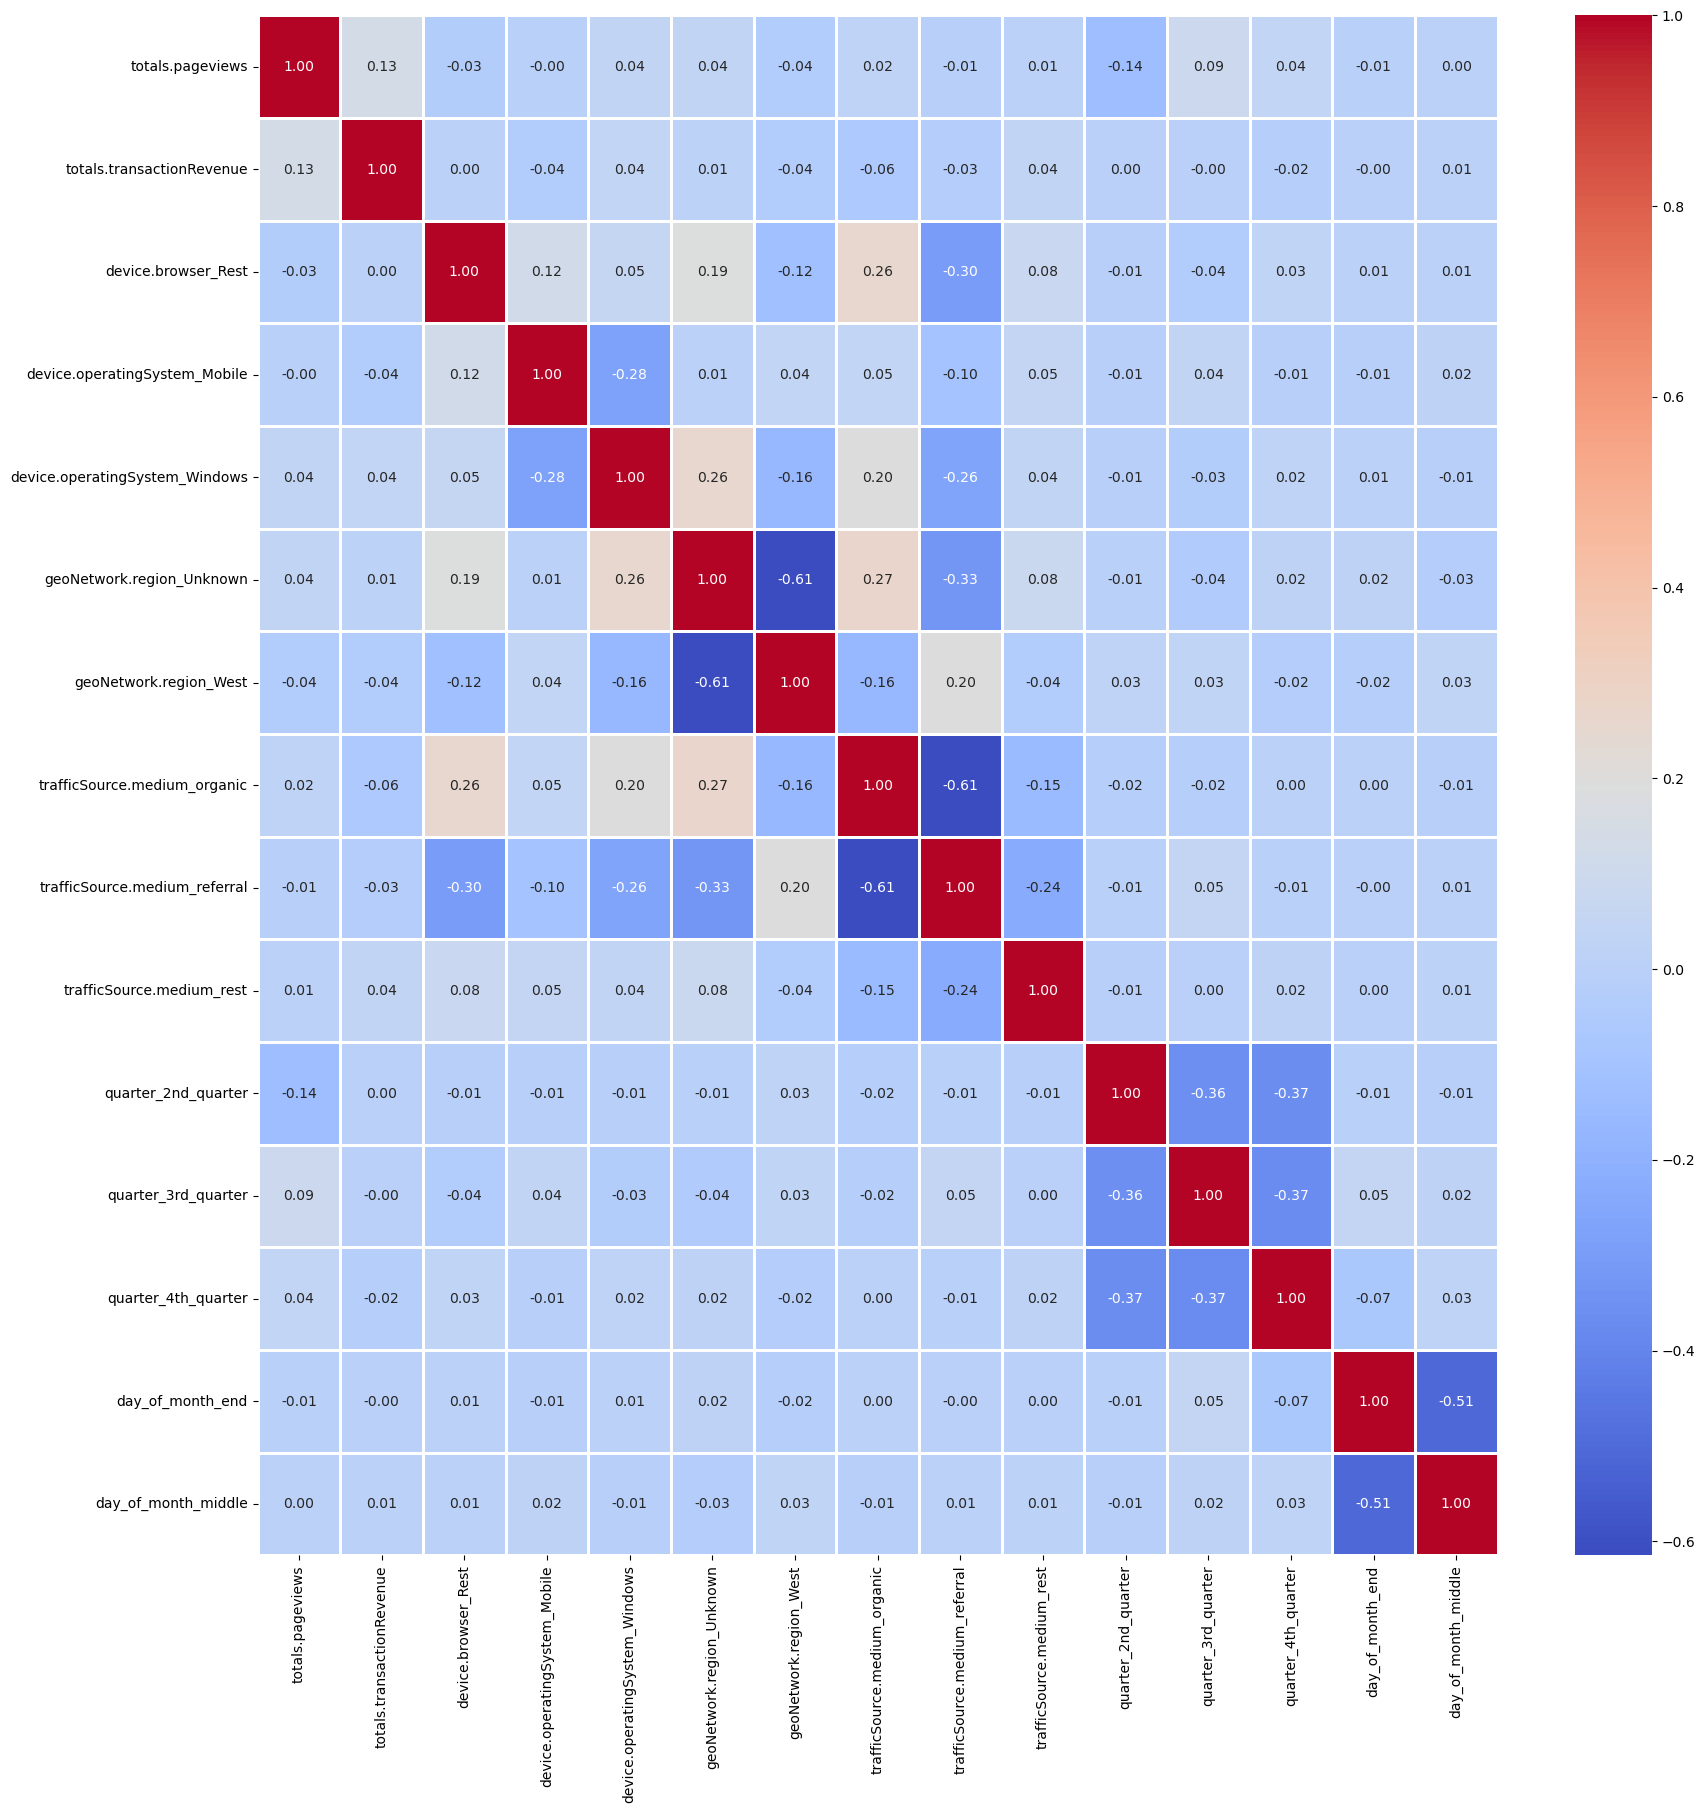

In [274]:
# give me the percentage of each value in the column
for column in df_4.columns:
    print(df_4[column].value_counts(normalize=True))
    print('\n')

# check the correlation between the columns
correlation = df_4.corr()
correlation

# plot the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.show()


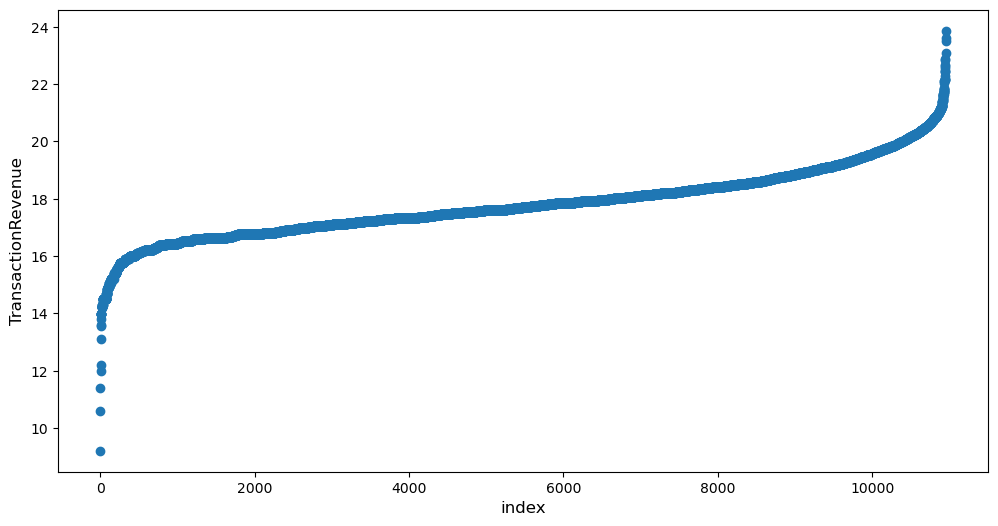

In [275]:
# plot the revenue
plt.figure(figsize=(12,6))
plt.scatter(range(df_4.shape[0]), np.sort(np.log1p(df_4["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()


In [291]:
df_5 = df_4.copy()
# get me the stats of the revenue in a table
print(df_5['totals.transactionRevenue'].min())
print(df_5['totals.transactionRevenue'].max())


10000.0
23129500000.0


In [277]:
# Min max on target
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#df_5['totals.transactionRevenue'] = scaler.fit_transform(df_5['totals.transactionRevenue'].values.reshape(-1,1))

df_5['totals.transactionRevenue'] = np.log1p(df_5['totals.transactionRevenue'].values)


In [278]:
# get me the stats of the revenue in a table
print(df_5['totals.transactionRevenue'].min())
print(df_5['totals.transactionRevenue'].max())

9.210440366976517
23.86437469605166


In [279]:
df_5.head()

,totals.pageviews,totals.newVisits,totals.transactionRevenue,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_Unknown,geoNetwork.region_West,trafficSource.medium_organic,trafficSource.medium_referral,trafficSource.medium_rest,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,17.449406,0,1,0,0,0,0,0,0,0,1,0,0,0
753,10,0,19.541283,0,0,0,0,0,1,0,0,0,1,0,0,0
799,11,0,18.035459,0,1,0,0,0,0,1,0,0,1,0,0,0
802,12,0,17.083177,0,0,1,0,1,0,1,0,0,1,0,0,0
859,14,0,20.168401,0,0,0,1,0,0,1,0,0,1,0,0,0


Mean Squared Error: 1.2553020337491887
Mean Absolute Error: 0.8631839361660864
Median Absolute Error: 0.8631839361660864
R^2 Score: 0.12919290215394175
Cross-validated scores: [0.85842117 0.81551634 0.85596021 0.87236524 0.85582436]
Average score: 0.8516174625464815
Intercept: 17.81686178043045
Coefficients: [ 0.30593111 -0.2029752  -0.084798   -0.0948675  -0.04434118 -0.12262109
 -0.10740589 -0.22252321 -0.16723227 -0.05742755  0.00887766 -0.01104059
 -0.03370372 -0.00427124  0.00217226]
Features: Index(['totals.pageviews', 'totals.newVisits', 'device.browser_Rest',
       'device.operatingSystem_Mobile', 'device.operatingSystem_Windows',
       'geoNetwork.region_Unknown', 'geoNetwork.region_West',
       'trafficSource.medium_organic', 'trafficSource.medium_referral',
       'trafficSource.medium_rest', 'quarter_2nd_quarter',
       'quarter_3rd_quarter', 'quarter_4th_quarter', 'day_of_month_end',
       'day_of_month_middle'],
      dtype='object')


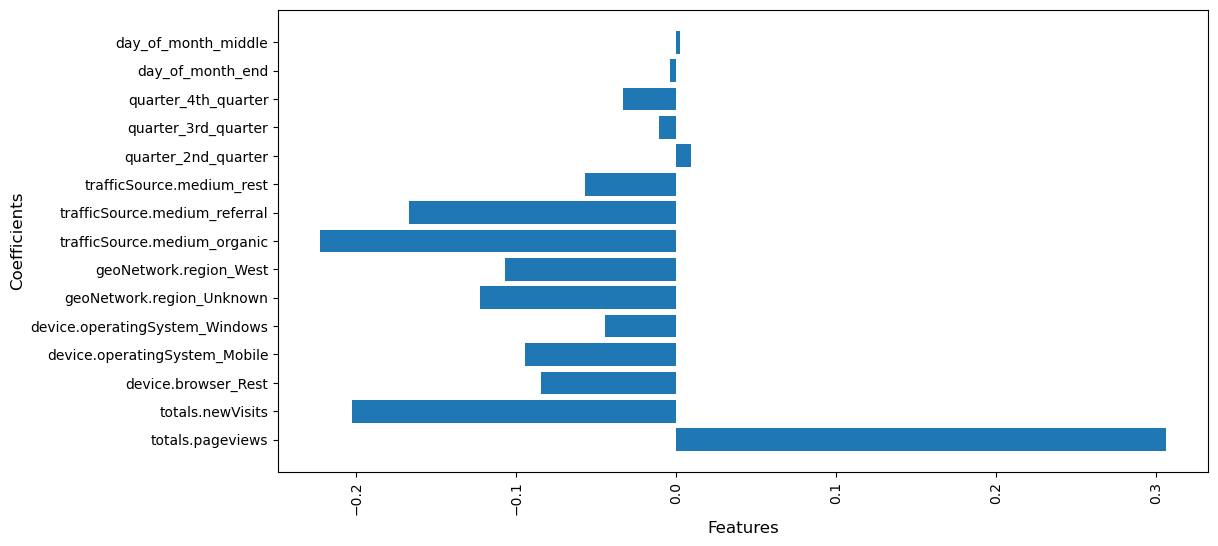

In [284]:
# Split the data into features and target
X = df_5.drop(columns='totals.transactionRevenue')
y = df_5['totals.transactionRevenue']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a standard scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, median_absolute_error

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Median Absolute Error
mae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)




print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", mae)



#cross validation
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores:', -scores)

# Print the average score
print('Average score:', -scores.mean())

# intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)

# plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()




In [290]:
def lc(x):
    return np.expm1(x)


Mean Squared Error: 1.4767865786291972
Mean Absolute Error: 0.9416846212787142
Median Absolute Error: 0.9416846212787142
Cross-validated scores: [0.92595225 0.90835246 0.93342571 0.94780889 0.94403123]
Average score: 0.9319141078620603


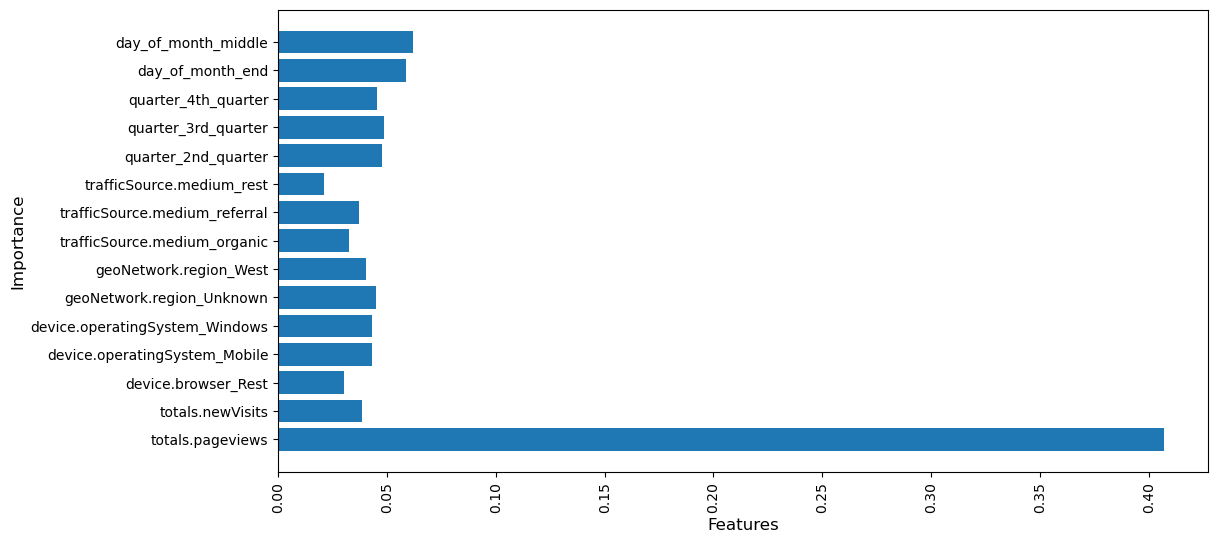

In [285]:
# other regression model
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae_rfr = median_absolute_error(y_test, y_pred)
mse_rfr = mean_squared_error(y_test, y_pred)
mae_rfr = mean_absolute_error(y_test, y_pred)




print("Mean Squared Error rfr:",mse_rfr)
print("Mean Absolute Error rfr:", mae_rfr)
print("Median Absolute Error rfr:", mae_rfr)


# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores:', -scores)

# Print the average score
print('Average score:', -scores.mean())


#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()



Mean Squared Error lasso: 1.3129285103044421
Mean Absolute Error lasso: 0.8822896325408653
Median Absolute Error lasso: 0.8822896325408653
Cross-validated scores lasso : [0.88022993 0.84531319 0.88936473 0.91074682 0.90121395]
Average score lasso: 0.8853737257136396


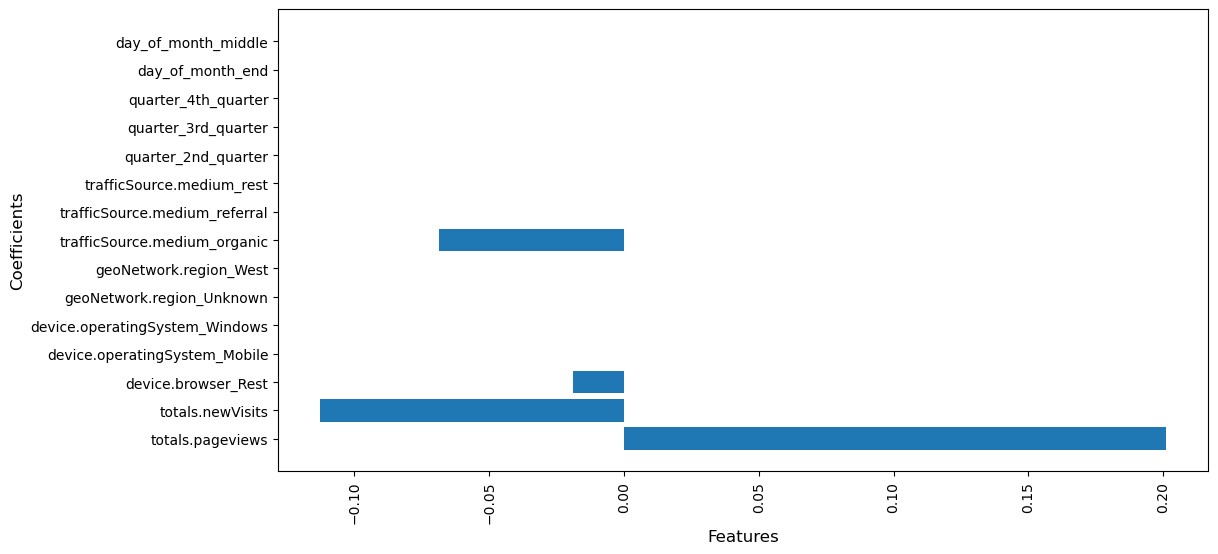

In [288]:
# lasso regression and ridge regression

from sklearn.linear_model import Lasso, Ridge

# Initialize the model
model = Lasso(alpha=0.1)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error lasso:", mse)
print("Mean Absolute Error lasso:", mae)
print("Median Absolute Error lasso:", mae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores lasso :', -scores)

# Print the average score
print('Average score lasso:', -scores.mean())

#plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()




Mean Squared Error ridge: 1.255301840905268
Mean Absolute Error ridge: 0.863183686584458
Median Absolute Error ridge: 0.863183686584458
Cross-validated scores ridge : [0.85841856 0.81551492 0.85595857 0.8723664  0.8558236 ]
Average score ridge: 0.8516164129760136


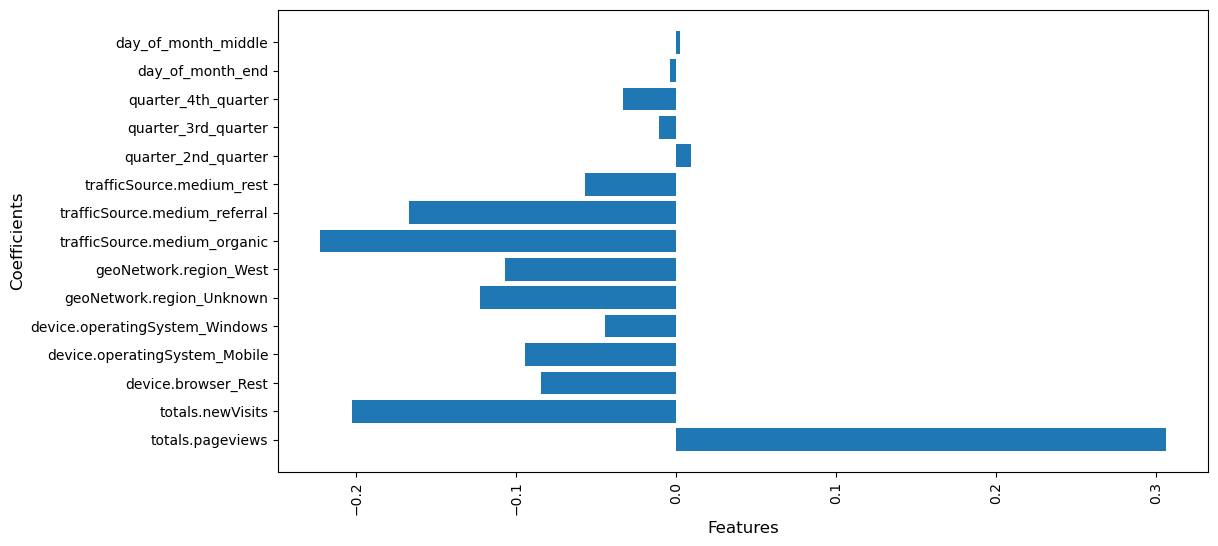

In [294]:

# Initialize the model
model = Ridge(alpha=0.1)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error ridge:", mse)
print("Mean Absolute Error ridge:", mae)
print("Median Absolute Error ridge:", mae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores ridge :', -scores)

# Print the average score
print('Average score ridge:', -scores.mean())

#plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()



In [296]:
#xgb regression
import xgboost as xgb

# Initialize the model
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error xgb:", mse)
print("Mean Absolute Error xgb:", mae)
print("Median Absolute Error xgb:", mae)







Mean Squared Error xgb: 1.3649966404743554
Mean Absolute Error xgb: 0.9031457703086637
Median Absolute Error xgb: 0.9031457703086637


In [293]:
#staking 
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb

# Initialize the base models

base_models = [
    ('lr', LinearRegression()),
    ('rfr', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR()),
    ('gbr', GradientBoostingRegressor()),
    ('abr', AdaBoostRegressor()),
    ('dt', DecisionTreeRegressor()),
    ('lasso', Lasso(alpha=0.1)),
    ('ridge', Ridge(alpha=0.1))
]

# Initialize the stacking model
model = StackingRegressor(estimators=base_models, final_estimator=RandomForestRegressor(n_estimators=100, random_state=42))

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error stacking:", mse)
print("Mean Absolute Error stacking:", mae)
print("Median Absolute Error stacking:", mae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores stacking :', -scores)

# Print the average score
print('Average score stacking:', -scores.mean())





Mean Squared Error stacking: 1.280346489457237
Mean Absolute Error stacking: 0.8728515168738936
Median Absolute Error stacking: 0.8728515168738936
Cross-validated scores stacking : [0.87374139 0.83122759 0.86337736 0.87455773 0.86286195]
Average score stacking: 0.8611532025737209


AttributeError: 'StackingRegressor' object has no attribute 'coef_'

<Figure size 1200x600 with 0 Axes>